In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [ ]:
import deepxde as dde 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

2023-10-08 11:45:41.253957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 11:45:41.254019: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 11:45:41.254052: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 11:45:41.262911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [ ]:
E = 50
nu = 0.3
a = 10
b = 10
f = 1
h = 1

## Data-driven Approach with Big data

### Load and Sample Data

In [ ]:
Plate_data = np.load('../Plate_data.npy')

loc = Plate_data[:, 0:2]
u = Plate_data[:, 2:3]
v = Plate_data[:, 3:4]
stress = Plate_data[:, 4:6]

In [ ]:
tr_sample = np.array([np.where(loc[:, 0] == i) for i in range(11)]).reshape(-1,)
tr_sample.shape

(1111,)

In [ ]:
x_sample = loc[tr_sample, :]
u_sample = u[tr_sample, :]
v_sample = v[tr_sample, :]

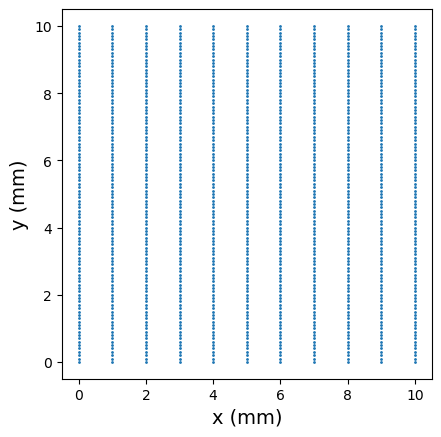

In [ ]:
plt.scatter(x_sample[:, 0], x_sample[:, 1], s=1)
plt.xlabel('x (mm)', fontsize = 14)
plt.ylabel('y (mm)', fontsize = 14)
plt.axis('square')
plt.show()

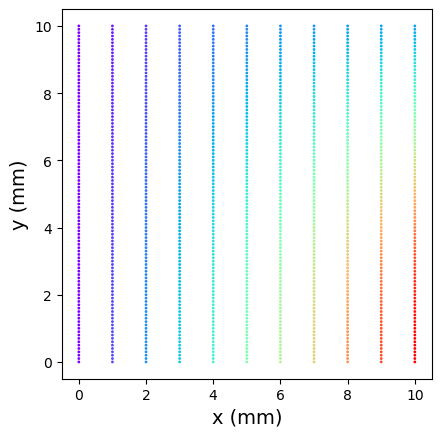

In [ ]:
plt.scatter(x_sample[:, 0], x_sample[:, 1], s=1, c=u_sample, cmap='rainbow')
plt.xlabel('x (mm)', fontsize = 14)
plt.ylabel('y (mm)', fontsize = 14)
plt.axis('square')
plt.show()

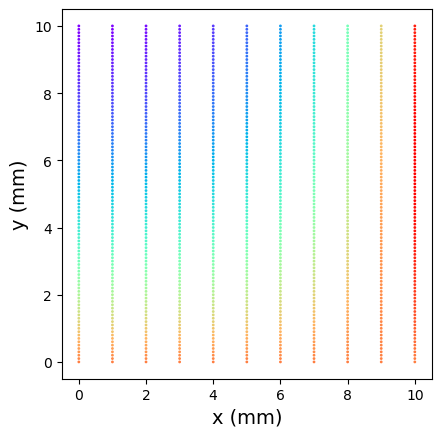

In [ ]:
plt.scatter(x_sample[:, 0], x_sample[:, 1], s=1, c=v_sample, cmap='rainbow')
plt.xlabel('x (mm)', fontsize = 14)
plt.ylabel('y (mm)', fontsize = 14)
plt.axis('square')
plt.show()

In [ ]:
x_sample.shape, u_sample.shape, v_sample.shape

((1111, 2), (1111, 1), (1111, 1))

In [ ]:
x_sample[:3], u_sample[:3], v_sample[:3]

(array([[0. , 0. ],
        [0. , 0.1],
        [0. , 0.2]]),
 array([[0.],
        [0.],
        [0.]]),
 array([[ 0.      ],
        [-0.000795],
        [-0.00159 ]]))

In [ ]:
observe_u = dde.icbc.PointSetBC(x_sample, u_sample, component=0)
observe_v = dde.icbc.PointSetBC(x_sample, v_sample, component=1)

2023-10-08 11:45:45.833065: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-08 11:45:45.834037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:81:00.0, compute capability: 7.0


### Define Geometry

In [ ]:
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[a, b])

In [ ]:
data = dde.data.PDE(geom,
                    None,
                    [observe_u, observe_v],
                    num_domain=0,
                    num_boundary=0,
                    num_test=100)

### Define Network and Hyper-parameters

In [ ]:
layer_size = [2] + [64] * 5 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, net)

In [ ]:
model.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.008180 s



### Train (Adam Optimizer)

Training model...



/userhome/jeon_mg/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2023-10-08 11:45:47.458324: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d817e08b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-08 11:45:47.458377: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-08 11:45:47.466784: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-08 11:45:48.073832: I tensorflow/compiler

Step      Train loss              Test loss               Test metric
0         [1.13e+00, 1.16e-01]    [1.13e+00, 1.16e-01]    []  
1000      [8.91e-06, 1.19e-05]    [8.91e-06, 1.19e-05]    []  
2000      [4.13e-06, 4.61e-06]    [4.13e-06, 4.61e-06]    []  
3000      [2.17e-06, 3.53e-06]    [2.17e-06, 3.53e-06]    []  
4000      [1.74e-06, 2.71e-06]    [1.74e-06, 2.71e-06]    []  
5000      [1.00e-06, 2.11e-06]    [1.00e-06, 2.11e-06]    []  
6000      [9.35e-07, 1.96e-06]    [9.35e-07, 1.96e-06]    []  
7000      [5.93e-06, 2.78e-06]    [5.93e-06, 2.78e-06]    []  
8000      [4.06e-07, 9.37e-07]    [4.06e-07, 9.37e-07]    []  
9000      [2.52e-07, 6.51e-07]    [2.52e-07, 6.51e-07]    []  
10000     [2.88e-06, 3.14e-06]    [2.88e-06, 3.14e-06]    []  

Best model at step 9000:
  train loss: 9.03e-07
  test loss: 9.03e-07
  test metric: []

'train' took 17.155382 s



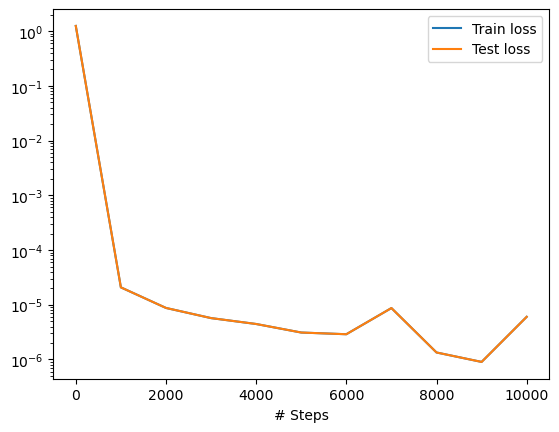

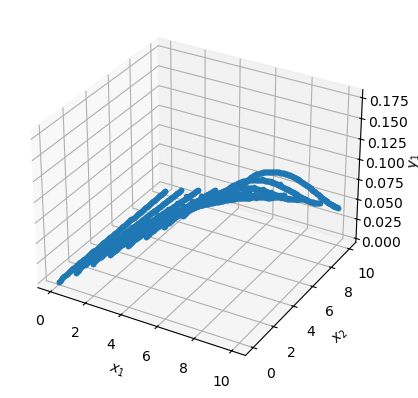

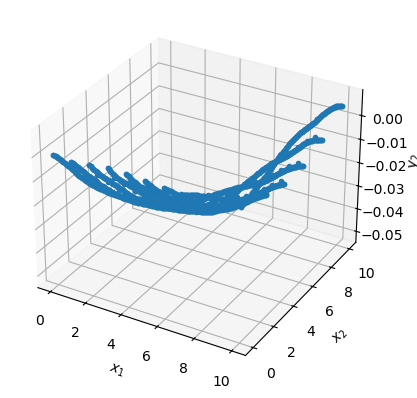

In [ ]:
loss_history, train_state = model.train(iterations=10000)
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Plot Results (Adam Optimizer)

In [ ]:
def check_stress(net, X):
    X = tf.constant(X)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        disp = net(X)
        u_pred = tf.reshape(disp[:, 0], [-1, 1])
        v_pred = tf.reshape(disp[:, 1], [-1, 1])
    
    du_X = tape.gradient(u_pred, X)
    dv_X = tape.gradient(v_pred, X)

    du_x, du_y = du_X[:, 0], du_X[:, 1]
    dv_x, dv_y = dv_X[:, 0], dv_X[:, 1]

    sig_xx = tf.reshape( (du_x + nu*dv_y)*E/(1-nu**2), [-1, 1] )
    sig_yy = tf.reshape( (dv_y + nu*du_x)*E/(1-nu**2), [-1, 1] )
    
    return sig_xx, sig_yy

In [ ]:
color_legend = [[0, 0.182], [-0.06, 0.011], [-0.0022, 1.0], [-0.15, 0.45]]
title = ['x-displacement ($u$)', 'y-displacement ($v$)', '$\sigma_{xx}$', '$\sigma_{yy}$']

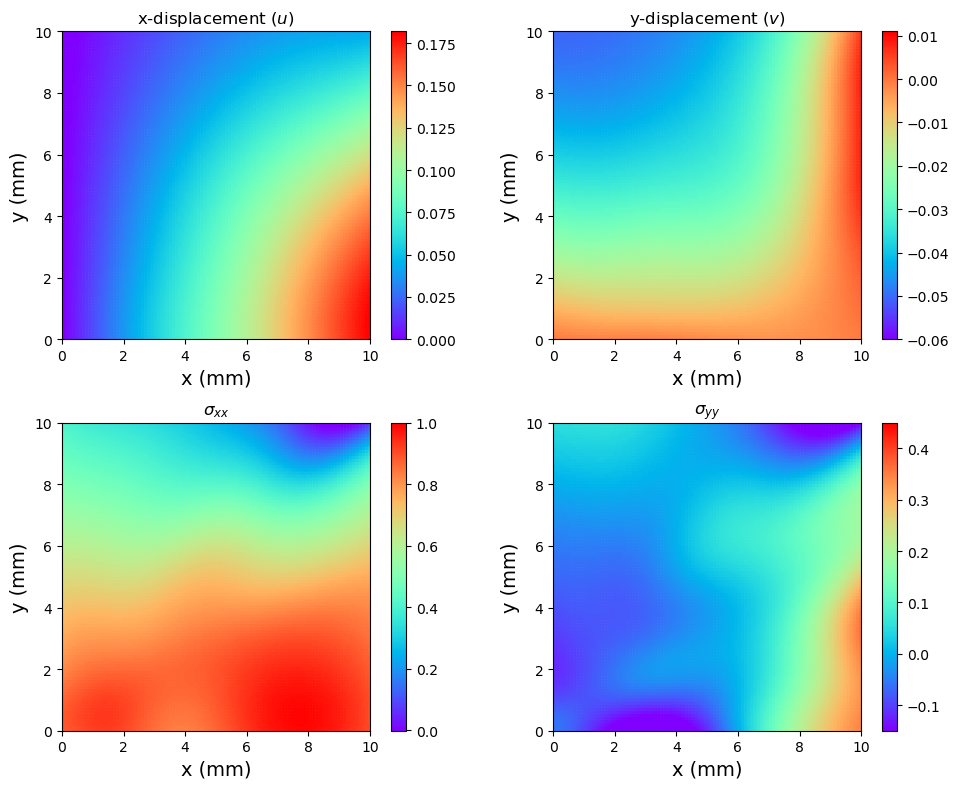

In [ ]:
samples = geom.uniform_points(10000)
big_disp = model.predict(samples)
big_sg = np.hstack(check_stress(model.net, samples))
big_result = np.hstack([big_disp, big_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=big_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()

### Train More (L-BFGS Optimizer)

Compiling model...
'compile' took 0.002544 s

Training model...

Step      Train loss              Test loss               Test metric
10000     [2.88e-06, 3.14e-06]    [2.88e-06, 3.14e-06]    []  
10603     [7.21e-09, 7.51e-09]    [7.21e-09, 7.51e-09]    []  

Best model at step 10603:
  train loss: 1.47e-08
  test loss: 1.47e-08
  test metric: []

'train' took 197.476461 s



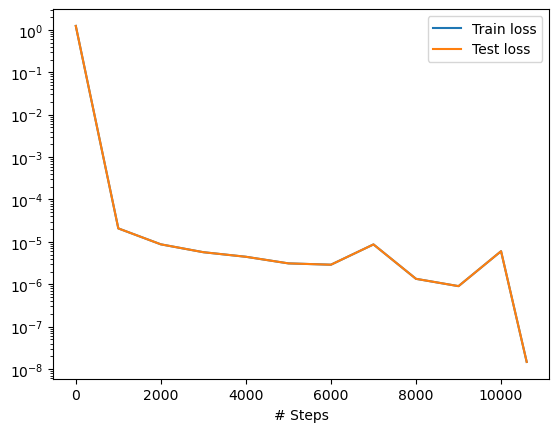

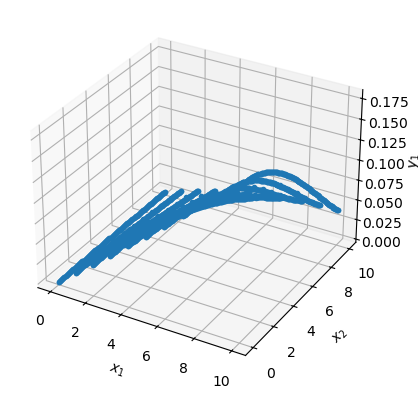

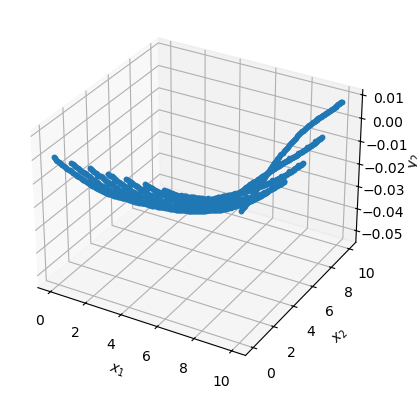

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile('L-BFGS')
loss_history, train_state = model.train()
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Plot Results (Adam + L-BFGS)

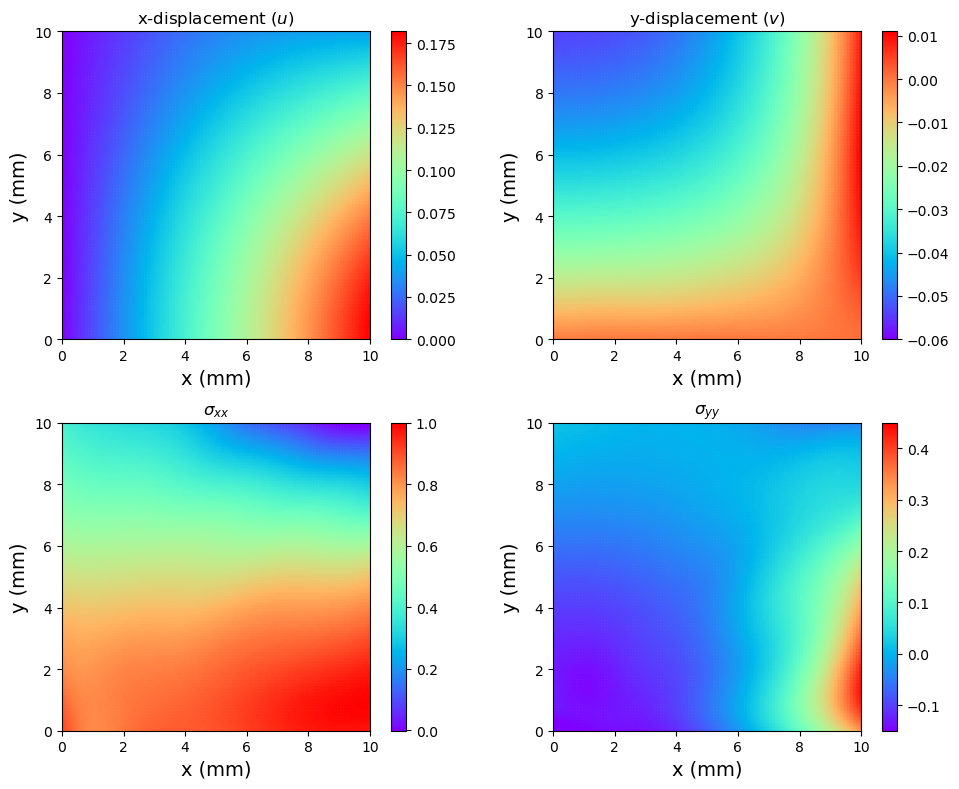

In [ ]:
samples = geom.uniform_points(10000)
big_disp = model.predict(samples)
big_sg = np.hstack(check_stress(model.net, samples))
big_result = np.hstack([big_disp, big_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=big_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()

### Save and Restore

In [ ]:
model.predict(samples)

array([[-0.00032754,  0.00027956],
       [-0.0002392 , -0.00063279],
       [-0.00016147, -0.00152185],
       ...,
       [ 0.04401216,  0.00833303],
       [ 0.04221734,  0.00826935],
       [ 0.04045228,  0.00820278]], dtype=float32)

In [ ]:
model.save('model/big', verbose=1)

Epoch 10603: saving model to model/big-10603.ckpt ...



'model/big-10603.ckpt'

In [ ]:
mm = dde.Model(data, net)

In [ ]:
mm.restore('model/big-10603.ckpt')

In [ ]:
mm.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.005499 s



In [ ]:
mm.predict(samples)

array([[-0.00032754,  0.00027956],
       [-0.0002392 , -0.00063279],
       [-0.00016147, -0.00152185],
       ...,
       [ 0.04401216,  0.00833303],
       [ 0.04221734,  0.00826935],
       [ 0.04045228,  0.00820278]], dtype=float32)

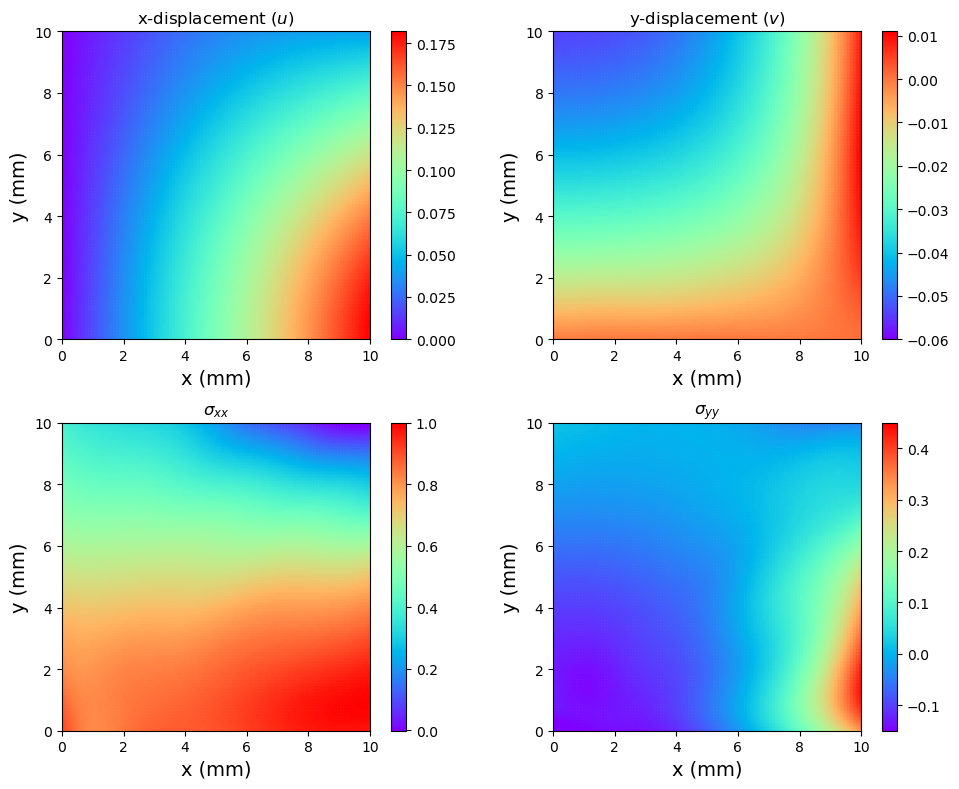

In [ ]:
samples = geom.uniform_points(10000)
big_disp = mm.predict(samples)
big_sg = np.hstack(check_stress(mm.net, samples))
big_result = np.hstack([big_disp, big_sg])

plt.figure(figsize=(10, 8))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=big_result[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlabel('x (mm)', fontsize = 14)
    plt.ylabel('y (mm)', fontsize = 14)
    plt.axis('square')
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()